In [1]:
import mercury as mr # for widgets
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

import time
import warnings
import pandas as pd
from itertools import cycle, islice

import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler


In [2]:
# pip install -r requirements.txt --upgrade

In [3]:
app = mr.App(title="Clutering test 1", description="Cluster input data set - test 1")


mercury.App

# Data Clustering (t1) - separate fluent data (demo)

### Clustering results for the fluent analysis data

Add background information or introduction here.

In [4]:
data_file = mr.File(label="Upload CSV")


mercury.File

In [5]:
# Import data file (.csv)

file_read = 0

if data_file.filepath:
    emp_np = pd.read_csv(data_file.filepath, skiprows=4).to_numpy()
    file_read = 1
    

### Clustering results

1. Compare the clustering results to find the best algorithm
2. Deselect "all" tab and choose the algoritm that returns best result.
3. Wait momentarilly, the grouped data will be saved in `\output\cluster_output.csv` automatically.

mercury.MultiSelect

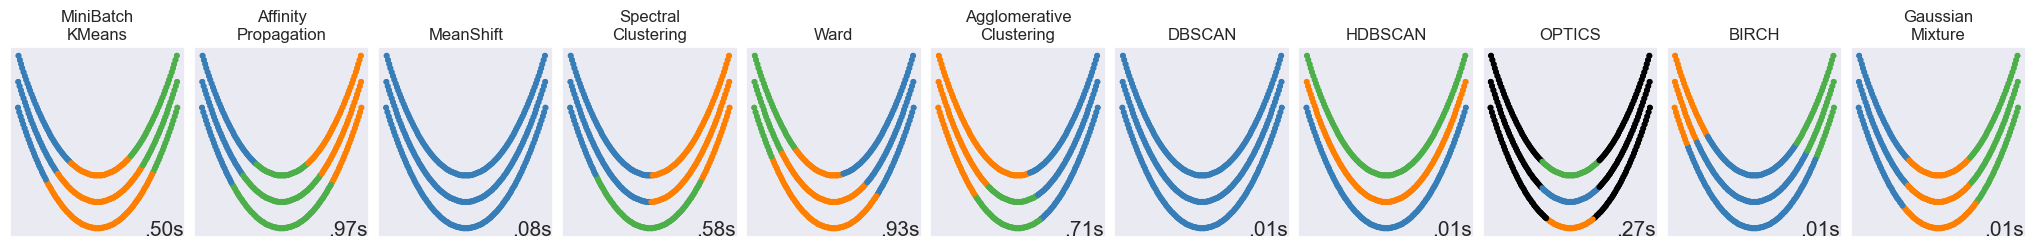

In [6]:
if file_read:

    # ============
    # Set up cluster parameters
    # ============
    plt.figure(figsize=(9 * 2 + 3, 2))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )
    
    plot_num = 1
    
    default_base = {
        "quantile": 0.3,
        "eps": 0.3,
        "damping": 0.9,
        "preference": -200,
        "n_neighbors": 3,
        "n_clusters": 3,
        "min_samples": 7,
        "xi": 0.05,
        "min_cluster_size": 0.1,
        "allow_single_cluster": True,
        "hdbscan_min_cluster_size": 15,
        "hdbscan_min_samples": 3,
    }
    
    
    datasets = [
        (
            (emp_np, []),
        
            {
            }    
        )
    ]
    
    (dataset, algo_params) = datasets[0]
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )
    
    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )
    
    if file_read:
    
        selected = mr.MultiSelect(label="Select a clustering method", 
                              choices=["MiniBatch\nKMeans", "Affinity\nPropagation", "MeanShift", "Spectral\nClustering","Ward", "Agglomerative\nClustering", "DBSCAN", "HDBSCAN", "OPTICS", "BIRCH", "Gaussian\nMixture", "all"],
                              value=["all"],
                         #     choices=[two_means, affinity_propagation, ms, spectral, ward, average_linkage, dbscan, hdbscan, optics, birch, gmm], 
                              url_key="selected")
    
        new_clustering_algorithms = [ali for ali in clustering_algorithms if ali[0] in selected.value]
    
        if "all" in selected.value:
            new_clustering_algorithms = clustering_algorithms
        
    
        for name, algorithm in new_clustering_algorithms:
            t0 = time.time()
        
            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning,
                )
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
                    category=UserWarning,
                )
                algorithm.fit(X)
        
            t1 = time.time()
            if hasattr(algorithm, "labels_"):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)
        
            axt = plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
            axt.set_title(name)
        
            colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )
            # add black color for outliers (if any)
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        
            # plt.xlim(-2.5, 2.5)
            # plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.text(
                0.99,
                0.01,
                ("%.2fs" % (t1 - t0)).lstrip("0"),
                transform=plt.gca().transAxes,
                size=15,
                horizontalalignment="right",
            )
            plot_num += 1

            # sort data points to groups
            df_out = pd.DataFrame(X)
            df_out['labels'] = y_pred
            clusters = [v for k, v in df_out.groupby('labels')]
            combined_data = pd.concat(clusters)
            
        
        plt.show()

In [8]:

output_dir = mr.OutputDir()
# Save combined data to a CSV file
combined_data.to_csv('cluster_output.csv', index=False)

mercury.OutputDir